In [198]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D
import time 
from scipy import stats
from scipy.stats import skew 
from scipy.stats import norm
from sklearn.neighbors import NearestNeighbors # importing the library
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn import metrics
from scipy.spatial.distance import cdist
from mpl_toolkits import mplot3d

import warnings
warnings.filterwarnings('ignore')

In [199]:
data_rfm = pd.read_csv('data/RFM_clean.csv')
data_rfm

,Recency,Frequency,Monetary
0,15,5,3113.890
1,27,3,5694.065
2,22,8,21613.800
3,12,4,6092.970
4,3,4,7597.980
...,...,...,...
5296,21,5,12574.900
5297,18,5,442.000
5298,34,2,5078.580
5299,40,2,3815.565


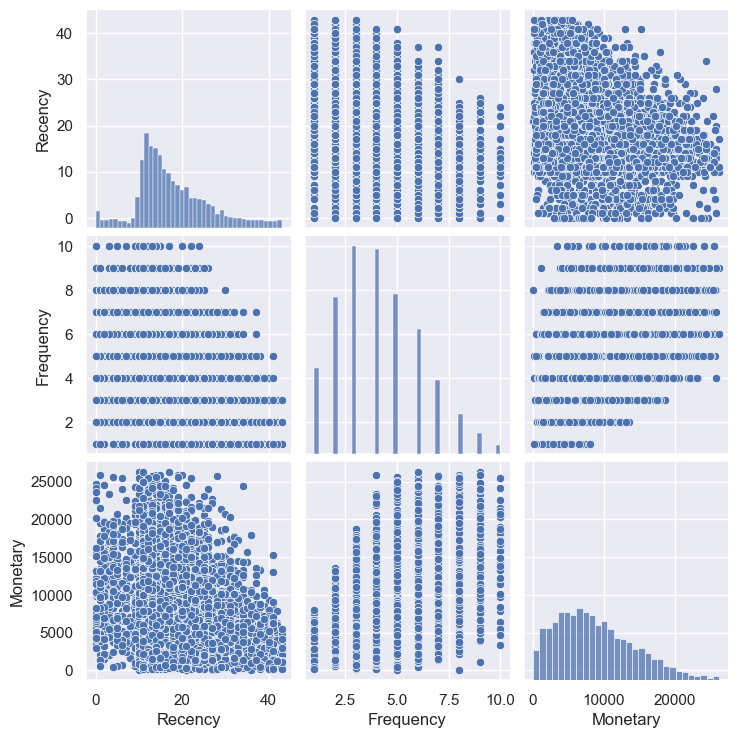

In [200]:
sns.pairplot(data_rfm)

Normalizing Data

In [201]:
def normalize_data(data, columns):
    scaler = preprocessing.MinMaxScaler()
    d = scaler.fit_transform(data[columns])
    scaled_df = pd.DataFrame(d, columns=columns)
    for c in columns :
        data['Norm'+c] = scaled_df[c]

In [202]:
normalize_data(data_rfm,['Recency','Frequency','Monetary'])

In [203]:
print(data_rfm.shape)

(5301, 6)


In [ ]:
# extracting the above mentioned columns
datos_final = data_rfm.loc[:, ['Recency',
                 'Monetary']].values

In [205]:
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(datos_final) # fitting the data to the object
distances,indices=nbrs.kneighbors(datos_final) # finding the nearest neighbours

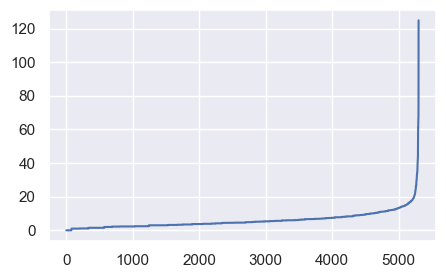

In [206]:
# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot


In [ ]:
def normalize_data(data, columns):
    scaler = preprocessing.MinMaxScaler()
    d = scaler.fit_transform(data[columns])
    scaled_df = pd.DataFrame(d, columns=columns)
    for c in columns :
        data['Norm'+c] = scaled_df[c]

In [ ]:
def normalize_data(data, columns):
    scaler = preprocessing.MinMaxScaler()
    d = scaler.fit_transform(data[columns])
    scaled_df = pd.DataFrame(d, columns=columns)
    for c in columns :
        data['Norm'+c] = scaled_df[c]

In [ ]:
# cluster the data into five clusters
dbscan = DBSCAN(eps = 8, min_samples = 4).fit(datos_final) # fitting the model
labels = dbscan.labels_ # getting the labels



AttributeError: 'numpy.ndarray' object has no attribute 'labels_'

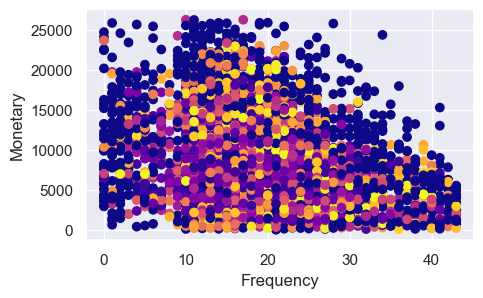

In [210]:
# Plot the clusters
plt.scatter(datos_final[:, 0], datos_final[:,1], c = labels, cmap= "plasma") # plotting the clusters
plt.xlabel("Frequency") # X-axis label
plt.ylabel("Monetary") # Y-axis label
plt.show() # showing the plot